In [1]:
# Import Libraries


import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from torchvision.transforms import ToPILImage
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from PIL import Image
import imagehash
import cv2

In [2]:
# ==============================
# 1. Dataset Preparation (CIFAR-10)
# ==============================
dataset_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=dataset_transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=dataset_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 170M/170M [00:37<00:00, 4.59MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


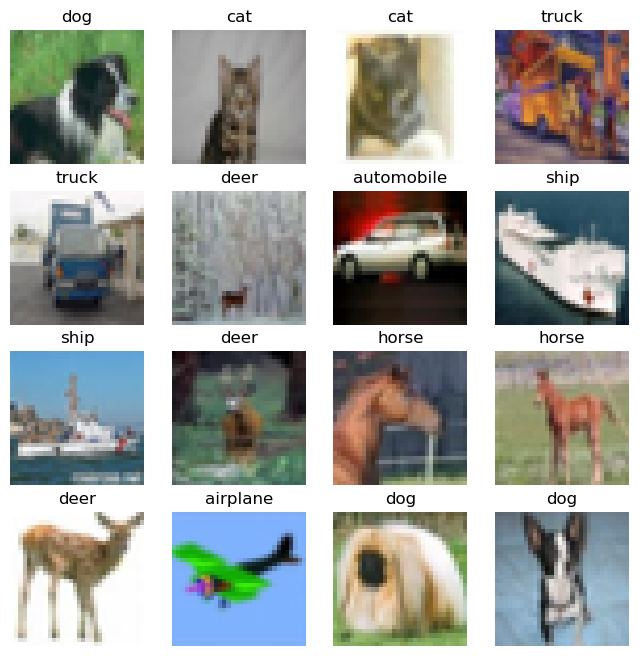

In [3]:
# Sample Visualization
classes = train_dataset.classes
sample_images, sample_labels = next(iter(train_loader))
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(sample_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)
    plt.title(classes[sample_labels[i]])
    plt.axis('off')
plt.show()

In [4]:

# ==============================
# 2. Methods for Similarity Search
# ==============================

# Method 1: Autoencoder-Based
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 32*32*3),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Train Autoencoder
autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

for epoch in range(5):  # Reduce epochs for simplicity
    for images, _ in train_loader:
        images = images.view(images.size(0), -1)
        encoded, decoded = autoencoder(images)
        loss = criterion(decoded, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def extract_resnet_features(image):
    # Check if image is a tensor and convert it to PIL Image
    if isinstance(image, torch.Tensor):
        to_pil = ToPILImage()
        image = to_pil(image)

    # Apply the transformation
    image = dataset_transform(image).unsqueeze(0)
    
    with torch.no_grad():
        features = resnet(image)
    
    return features.view(-1).numpy()


In [5]:
# Method 2: Pretrained CNN (ResNet)
from torchvision import models

resnet = models.resnet18(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove classification layer
resnet.eval()

def extract_resnet_features(image):
    # If image is a tensor, we don't need to apply the transformation
    if isinstance(image, torch.Tensor):
        image = image.unsqueeze(0)  # Make sure the image is in batch form

    with torch.no_grad():
        features = resnet(image)  # Pass it through the ResNet model
    return features.view(-1).numpy()



c:\Users\Pronita Barman\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Pronita Barman\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Method 3: Perceptual Hashing (pHash)
def get_phash(image):
    image = Image.fromarray(np.uint8(image.numpy().transpose(1, 2, 0) * 255)).convert('L')
    return imagehash.phash(image)

In [7]:
# Method 4: Feature Matching using ORB (Oriented FAST and Rotated BRIEF)
def orb_feature_matching(img1, img2):
    # Step 1: Initialize the ORB detector
    orb = cv2.ORB_create()  # ORB (Oriented FAST and Rotated BRIEF) is a fast and efficient feature detection and description algorithm.

    # Step 2: Detect keypoints and compute descriptors for the first image
    # Keypoints represent distinct visual features in the image, and descriptors encode the appearance of those features.
    kp1, des1 = orb.detectAndCompute(img1, None)

    # Step 3: Detect keypoints and compute descriptors for the second image
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Step 4: Create a Brute Force Matcher (BFMatcher) with the Hamming distance as the similarity metric
    # The Hamming distance is used because ORB descriptors are binary strings.
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Step 5: Match the descriptors from both images
    # crossCheck=True ensures that the matching is mutual, meaning A->B and B->A.
    matches = bf.match(des1, des2)

    # Step 6: Return the number of matches found
    # This gives an indication of similarity between the two images.
    return len(matches)


In [8]:
def get_latent_representation(image):
    # Ensure the image is a flattened tensor
    if len(image.shape) > 2:  # If the image is not flattened
        image = image.view(1, -1)  # Flatten and add a batch dimension
    
    # Pass the image through the encoder to get the latent representation
    with torch.no_grad():
        encoded, _ = autoencoder(image)
    
    return encoded

In [9]:
def histogram_similarity(query_image, test_images):
    # Convert the query image from a PyTorch tensor to a NumPy array
    query_image_np = query_image.permute(1, 2, 0).numpy() * 255  # Convert to HWC and scale to [0, 255]
    query_image_np = query_image_np.astype('uint8')  # Ensure it's in uint8 format

    # Compute the histogram for the query image
    query_hist = cv2.calcHist([query_image_np], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    query_hist = cv2.normalize(query_hist, query_hist).flatten()

    results = []
    for img in test_images:
        # Convert each test image to NumPy and ensure it's in uint8 format
        test_image_np = img.permute(1, 2, 0).numpy() * 255
        test_image_np = test_image_np.astype('uint8')

        # Compute the histogram for the test image
        test_hist = cv2.calcHist([test_image_np], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        test_hist = cv2.normalize(test_hist, test_hist).flatten()

        # Compare the histograms using correlation
        score = cv2.compareHist(query_hist, test_hist, cv2.HISTCMP_CORREL)
        results.append(score)

    return results



In [10]:
def template_matching_similarity(query_image, test_images):
    results = []

    # Convert query image to numpy format and grayscale
    query_image_np = query_image.permute(1, 2, 0).numpy() * 255
    query_image_np = query_image_np.astype('uint8')
    query_gray = cv2.cvtColor(query_image_np, cv2.COLOR_RGB2GRAY)

    for img in test_images:
        # Convert test image to numpy format and grayscale
        test_image_np = img.permute(1, 2, 0).numpy() * 255
        test_image_np = test_image_np.astype('uint8')
        test_gray = cv2.cvtColor(test_image_np, cv2.COLOR_RGB2GRAY)

        # Perform template matching using normalized correlation
        res = cv2.matchTemplate(test_gray, query_gray, cv2.TM_CCOEFF_NORMED)

        # Find the maximum similarity score
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        results.append(max_val)  # Higher value indicates more similarity

    return results

In [11]:
def sift_feature_matching(query_image, test_images):
    sift = cv2.SIFT_create()

    # Convert the query image to grayscale
    query_image_np = query_image.permute(1, 2, 0).numpy() * 255
    query_image_np = query_image_np.astype('uint8')
    query_image_np = cv2.cvtColor(query_image_np, cv2.COLOR_RGB2GRAY)

    # Detect and compute keypoints and descriptors for the query image
    kp1, des1 = sift.detectAndCompute(query_image_np, None)

    results = []
    for img in test_images:
        # Convert each test image to grayscale
        test_image_np = img.permute(1, 2, 0).numpy() * 255
        test_image_np = test_image_np.astype('uint8')
        test_image_np = cv2.cvtColor(test_image_np, cv2.COLOR_RGB2GRAY)

        # Detect and compute keypoints and descriptors for the test image
        kp2, des2 = sift.detectAndCompute(test_image_np, None)

        # Check if descriptors are available
        if des1 is not None and des2 is not None:
            bf = cv2.BFMatcher()
            matches = bf.knnMatch(des1, des2, k=2)

            # Apply relaxed ratio test
            good_matches = [m for m, n in matches if m.distance < 0.85 * n.distance]
            results.append(len(good_matches))
        else:
            results.append(0)  # No matches if descriptors are missing
    
    return results


In [12]:
def compute_similarity(query_image, test_images):
    results = {}

    # Autoencoder
    query_encoded = get_latent_representation(query_image.view(1, -1))
    autoencoder_similarities = [cosine_similarity(query_encoded, get_latent_representation(img.view(1, -1)))[0][0] for img in test_images]
    results['Autoencoder'] = autoencoder_similarities

    # ResNet
    query_resnet = extract_resnet_features(query_image).reshape(1, -1)  # Reshape to 2D array
    resnet_similarities = [cosine_similarity(query_resnet, extract_resnet_features(img).reshape(1, -1))[0][0] for img in test_images]
    results['ResNet'] = resnet_similarities

    # Perceptual Hashing
    query_phash = get_phash(query_image)
    phash_distances = [abs(query_phash - get_phash(img)) for img in test_images]
    results['pHash'] = phash_distances

     # Histogram Comparison
    histogram_scores = histogram_similarity(query_image, test_images)
    results['Histogram'] = histogram_scores

     # Template Matching
    template_scores = template_matching_similarity(query_image, test_images)
    results['Template Matching'] = template_scores

    return results

Test Image ResNet shape: (1, 512)
Autoencoder Scores: [0.23790969, 0.2691872, 0.46622145, 0.3407514, 0.60119593, 0.5370414, 0.64096624, 0.4511268, 0.28142893]
ResNet Scores: [0.47303426, 0.5303236, 0.513292, 0.37290803, 0.5027324, 0.54882026, 0.3696453, 0.53774154, 0.55288804]
pHash Scores: [36, 26, 32, 34, 36, 38, 36, 32, 32]
Histogram Scores: [0.18297293563111902, 0.19513159897938034, 0.1859916470516695, -0.017349221258809923, -0.05568973920921887, 0.07661692762427401, 0.1809042309791094, 0.20084693803685633, 0.17071649422347315]
Template Matching Scores: [0.02550792321562767, 0.07891575247049332, -0.04202713817358017, -0.024955332279205322, 0.004357436206191778, -0.016498206183314323, 0.05375675857067108, 0.12220980226993561, -0.016708463430404663]


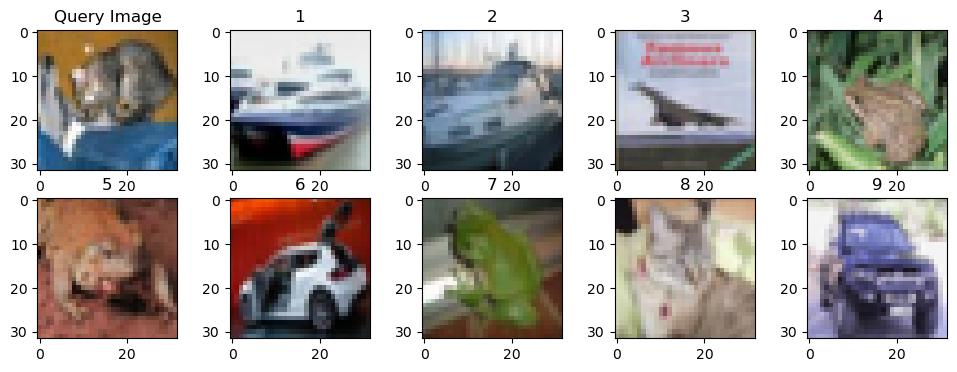

In [13]:
# =============================
# 4. Visualization and README Preparation
# =============================
# Comparing Methods
query, _ = test_dataset[0]
test_images = [test_dataset[i][0] for i in range(1, 10)]
similarities = compute_similarity(query, test_images)
print("Test Image ResNet shape:", extract_resnet_features(test_images[0]).reshape(1, -1).shape)

for method, scores in similarities.items():
    print(f"{method} Scores: {scores}")

# Visualizing Results
plt.figure(figsize=(12, 4))
plt.subplot(2, 5, 1)
plt.imshow(query.permute(1, 2, 0).numpy() * 0.5 + 0.5)
plt.title("Query Image")
for i, img in enumerate(test_images):
    plt.subplot(2, 5, i+2)
    plt.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
    plt.title(f"{i+1}")
plt.show()